# Zadanie nr 1.2.4 - Rozwiązywanie zadania klasyfikacji
## Metody Inteligencji Obliczeniowej w Analizie Danych
### Paweł Koźmiński, 298825

Kolejne, czwarte zadanie z laboratoriów Metod Inteligencji Obliczeniowej polegało na rozszerzeniu dotychczasowej implementacji sieci o możliwość rozwiązywania zadania klasyfikacji poprzez dodanie możliwości użycia funkcji aktywacji `softmax` w wyjściowej warstwie modelu.
Poprawność implementacji należało zweryfikować, rozwiązując zadanie klasyfikacji na zbiorach danych:
- `rings3-regular`,
- `easy`,
- `xor3`.

In [1]:
import math
import numpy as np
from scipy.misc import derivative
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics, preprocessing
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score
import networkx as nx

import logging
logging.getLogger().setLevel(logging.CRITICAL)

def sigmoid(x):
    return 1/(1+np.exp(-x))

class Net:
    def __init__(self, n_inputs, hidden_neurons_n, n_outputs, weights, hidden_activation_fun=sigmoid,
                 last_activation_fun='linear', uniform_weights_limits = (-1, 1)):
        """
        Constructor of object Net takes many arguments required for building a model:
        n_inputs - number of inputs to the net
        hidden_neurons_n - list of integers pointing the size of hidden layers
        n_outputs - expected size of output
        weights - a string, one of "He", "Xavier", "Uniform", depending on desired method of drawing the initializing weights.
        The possibility of manually input the weights has been disactivated.
        hidden_activation_fun - activation function used in hidden layers
        last_activation_fun - activation function used in last layer
        uniform_weights_limits - a tuple, used only if weights = "Uniform", indicating the parameters (lower, upper) of the uniform distribution to draw the weights from.
        
        """
        self.last_activation_fun = last_activation_fun
        if last_activation_fun == 'linear':
            l_a_f = lambda x: x
        elif last_activation_fun == 'sigmoid':
            l_a_f = lambda x: 1/(1+np.exp(-x))
        elif last_activation_fun == 'softmax':
            def l_a_f(x):
                exp_x = np.exp(x)
                if exp_x.ndim > 1:
                    exp_sum = np.sum(exp_x, axis=1)[:, np.newaxis]
                else:
                    exp_sum = np.sum(exp_x)
                return exp_x/exp_sum
        else:
            raise AttributeError(f'Activation function {last_activation_fun} has not been implemented yet')
        Layers = [self.Layer(n_inputs, hidden_neurons_n[0], weights, None, hidden_activation_fun, uniform_weights_limits)]
        Layers = Layers + [self.Layer(hidden_neurons_n[j], hidden_neurons_n[j+1], weights, None, hidden_activation_fun,
                                       uniform_weights_limits) for j in range(len(hidden_neurons_n)-1)]
        Layers = Layers + [self.Layer(hidden_neurons_n[-1], n_outputs, weights, None, l_a_f, uniform_weights_limits)]
        self.layers_list = Layers
        self.layers_size = [n_inputs] + hidden_neurons_n + [n_outputs]
        
    def train(self, data, optimisation = None, optimisation_param = 0.2, learning_rate=0.005, epochs=5,
              batch_size = 1, plot = True, verbose = True):
        """
        data - numpy.array of numpy arrays of shape (2, ...) where first element is the input and the second is output.
        Due to the structure of numpy array, both inputs and labels need to be of the same length. Please fill the shorter one with any values just to align it.
        Only first <n_inputs> or <n_outputs> will be taken into consideration.
        optimisation - one of None, 'momentum' or 'RMSProp' - method of optimisation method
        optimisation_param - used when optimisation is not None - parameter of chosen method
        batch_size - number of observations presented to the net in one iteration. When batch_size>len(data) it is minimised to len(data)
        plot - should the net be visualized during training?
        """
        if not (optimisation is None or optimisation == "momentum" or optimisation == "rmsprop"):
            raise AttributeError(f"Invalid value of optimisation type: {optimisation}")
        #create net graph
        if plot:
            G = nx.Graph()
            G.add_nodes_from(range(sum(self.layers_size)))
            #add edges to graph
            pom = 0
            pom2 = 0
            for k in range(len(self.layers_size)-1):
                pom += self.layers_size[k]
                for i in range(pom2, pom):
                    for j in range(pom, pom+self.layers_size[k+1]):
                        G.add_edge(i, j)
                pom2 += self.layers_size[k]
        #let's train:
        for k in range(epochs):
            if verbose: print(f"Epoch {k+1} out of {epochs} ({round((k)/epochs*100)}%)")
            
            for n_batch in range(0, len(data), batch_size):
                cur_data = data[n_batch:(min((n_batch+batch_size), len(data))),:,:] #slicing the data to batch
                changing_x = cur_data[:,0, 0:self.layers_size[0]] #independent values
                expected_y = cur_data[:,1,0:self.layers_size[len(self.layers_size)-1]] #target
                
                for i in range(0, len(self.layers_list)): #feed forward
                    changing_x = self.layers_list[i].go(changing_x)

                for i in range(len(self.layers_list)-1, -1, -1): #back propagation
                    if i == len(self.layers_list)-1: #the last layer is a little bit different
                        if self.last_activation_fun == 'linear' or self.last_activation_fun == 'sigmoid':
                            self.layers_list[i].err = (changing_x-expected_y)\
                            *derivative(self.layers_list[i].activation_fun, self.layers_list[i].activation_argument, dx = 1e-10)
                        elif self.last_activation_fun == 'softmax':
                            # in case of softmax - a vector function - its not that easy...
                            # the jacobian must be calculated for every observation in a batch
                            # and it's structure is (I-p)*p.reshape(-1,1) where p is a vector of probabilites.
                            #self.layers_list[i].err = np.zeros(expected_y.shape)
                            #for ix in range(len(expected_y)):
                            #    cur_vec = changing_x[ix,:]
                            #    self.layers_list[i].err[ix,:] = np.matmul((cur_vec-expected_y[ix,:]), np.subtract(np.identity(len(cur_vec)), cur_vec) * cur_vec.reshape(-1, 1))
                            #
                            # vector operations - with 3d-matrix multiplication but without slower loop (45% time reduction)
                            tmp_errors = (changing_x-expected_y).reshape(expected_y.shape[0], 1, expected_y.shape[1])
                            identity3d = np.repeat(np.identity(expected_y.shape[1])[np.newaxis, :, :], expected_y.shape[0], 0)
                            d = changing_x.reshape(changing_x.shape[0], 1, changing_x.shape[1])
                            jacobians =  (identity3d-d) * d.reshape(d.shape[0],-1, 1)
                            self.layers_list[i].err = np.squeeze(np.matmul(tmp_errors, jacobians))
                    if i>0: #other layers
                        self.layers_list[i-1].err = np.dot(self.layers_list[i].err, np.transpose(self.layers_list[i].weights))\
                        *derivative(self.layers_list[i-1].activation_fun, self.layers_list[i-1].activation_argument, dx = 1e-10)
                # weights correction
                if optimisation is None: 
                    for i in range(len(self.layers_list)-1, -1, -1):
                        weights_delta = -1 * learning_rate * np.dot(np.transpose(self.layers_list[i].input_values), self.layers_list[i].err)/len(cur_data) #mean of gradients
                        bias_delta = (-1 * learning_rate * self.layers_list[i].err).reshape(len(cur_data), self.layers_list[i].neurons)
                        bias_delta = np.mean(bias_delta, axis = 0)
                        self.layers_list[i].weights += weights_delta
                        self.layers_list[i].bias += bias_delta.reshape(-1,)
                elif optimisation == "momentum":
                    for i in range(len(self.layers_list)-1, -1, -1):
                        weights_delta = -1 * np.dot(np.transpose(self.layers_list[i].input_values), self.layers_list[i].err)/len(cur_data) #mean of gradients
                        bias_delta = (-1 * self.layers_list[i].err).reshape(len(cur_data), self.layers_list[i].neurons)
                        bias_delta = np.mean(bias_delta, axis = 0)
                        self.layers_list[i].optimisation_weights *= optimisation_param
                        self.layers_list[i].optimisation_weights += weights_delta
                        self.layers_list[i].optimisation_bias *= optimisation_param
                        self.layers_list[i].optimisation_bias += bias_delta.reshape(-1,)
                        self.layers_list[i].weights += learning_rate * self.layers_list[i].optimisation_weights
                        self.layers_list[i].bias += learning_rate * self.layers_list[i].optimisation_bias
                else: #optimisation == "rmsprop"
                    for i in range(len(self.layers_list)-1, -1, -1):
                        g_weights = np.dot(np.transpose(self.layers_list[i].input_values), self.layers_list[i].err)/len(cur_data) #mean of gradients
                        g_bias = self.layers_list[i].err.reshape(len(cur_data), self.layers_list[i].neurons)
                        g_bias = np.mean(g_bias, axis = 0).reshape(-1,)
                        self.layers_list[i].optimisation_weights *= optimisation_param
                        self.layers_list[i].optimisation_weights += (1-optimisation_param) * np.power(g_weights, 2)
                        self.layers_list[i].optimisation_bias *= optimisation_param
                        self.layers_list[i].optimisation_bias += (1-optimisation_param) * np.power(g_bias, 2)
                        self.layers_list[i].weights -= learning_rate * (g_weights/np.sqrt(self.layers_list[i].optimisation_weights))
                        self.layers_list[i].bias -= learning_rate * (g_bias/np.sqrt(self.layers_list[i].optimisation_bias))
            
            #add weights to the graph plot
            if plot and k % max(1, (round(epochs/15))) == 0:
                edge_labels = dict()
                for z in range(0, len(self.layers_size)-1):
                    edge_labels = {**edge_labels, **{(i, j): round(self.layers_list[z].weights[i-(0 if z==0 else np.cumsum(self.layers_size)[z-1]),j-np.cumsum(self.layers_size)[z]], 2)
                                    for i in range(0 if z==0 else np.cumsum(self.layers_size)[z-1],np.cumsum(self.layers_size)[z])
                                    for j in range(np.cumsum(self.layers_size)[z],np.cumsum(self.layers_size)[z+1])}}
                plt.figure(figsize = (10, 6))
                # nodes position:
                pos = {j: (p, 1/(self.layers_size[p]+1)*(j-(0 if p==0 else np.cumsum(self.layers_size)[p-1])+1)) 
                                    for p in range(len(self.layers_size))
                                    for j in range(0 if p==0 else np.cumsum(self.layers_size)[p-1], np.cumsum(self.layers_size)[p])}
                nx.draw_networkx(G, pos, alpha = 0.9, with_labels=False)
                #Displaying edge labels on different positions:
                edge_labels_list = list(edge_labels.items())
                nx.draw_networkx_edge_labels(G,pos, edge_labels=dict(edge_labels_list[::4]), label_pos = 0.2, font_color = 'red')
                nx.draw_networkx_edge_labels(G,pos, edge_labels=dict(edge_labels_list[1::4]), label_pos = 0.4, font_color = 'red')
                nx.draw_networkx_edge_labels(G,pos, edge_labels=dict(edge_labels_list[2::4]), label_pos = 0.6, font_color = 'red')
                nx.draw_networkx_edge_labels(G,pos, edge_labels=dict(edge_labels_list[3::4]), label_pos = 0.8, font_color = 'red')
                plt.show()
        #finally, return the predicted output:
        changing_x = data[:,0,0:self.layers_size[0]] 
        for i in range(0, len(self.layers_list)): #feed forward
                changing_x = self.layers_list[i].go(changing_x)
        return changing_x # note that when used for classification - only probabilities are returned
    def predict(self, x):
        """
        x - numpy array of inputs to be predicted by (assumably already trained) Net
        """
        changing_x = x[:, 0:self.layers_size[0]]
        for i in range(0, len(self.layers_list)):
                changing_x = self.layers_list[i].go(changing_x)
        return changing_x
    
    class Layer:
        def __init__(self, n_inputs, neurons, weights, bias, activation_fun, uniform_weights_limits=(-1, 1)):
            """
            The constructor of Layer class takes as arguments:
            n_inputs - number of inputs into a layer,
            neurons - number of layers in a layer,
            weights - weights of inputs of a layer - highly recommended for weights to be of class numpy.array or "He"/"Xavier"/"Uniform"
            bias - values of bias - preferably numpy.array as well,
            activation - activation function (possibly lambda function) 
            """
            self.neurons = neurons
            self.n_inputs = n_inputs
            self.activation_fun = activation_fun
            if weights == "He":
                weights = np.random.normal(scale=np.sqrt(2/n_inputs), size = (n_inputs, neurons))
                bias = np.random.normal(scale=np.sqrt(2/n_inputs), size = (neurons,))
            elif weights == "Xavier":
                weights = np.random.uniform(-np.sqrt(6/(neurons+n_inputs)), np.sqrt(6/(neurons+n_inputs)), size = (n_inputs, neurons))
                bias = np.random.uniform(-np.sqrt(6/(neurons+n_inputs)), np.sqrt(6/(neurons+n_inputs)), size = (neurons,))
            elif weights == "Uniform":
                weights = np.random.uniform(uniform_weights_limits[0], uniform_weights_limits[1], (n_inputs, neurons))
                bias = np.random.uniform(uniform_weights_limits[0], uniform_weights_limits[1], (neurons,))
            if len(weights.shape) == 1:
                weights = weights.reshape(1, -1)
            if weights.shape == (n_inputs, neurons):
                self.weights = weights
            else:
                raise AttributeError("The dimensions of weights are not aligned")
            if len(weights.shape) == 1:
                if len(bias) == len(weights):
                    self.bias = bias
            elif len(bias) == weights.shape[1]:
                self.bias = bias
            else:
                raise AttributeError("Incorrect length of bias")
            self.activation_argument = None
            self.err = None
            self.out_value = None
            self.input_values = None
            self.optimisation_weights = np.zeros((self.n_inputs, self.neurons))
            self.optimisation_bias = np.zeros((self.neurons,))
        def go(self, x_input):
            """
            x_input - numpy.array containing data used in a layer.
            """
            if x_input.shape[1] != self.n_inputs:
                raise AttributeError("The dimensions of input are incorrect for this layer")
            self.input_values = x_input
            self.activation_argument = np.dot(x_input, self.weights) + self.bias            
            self.out_value = self.activation_fun(self.activation_argument)
            return self.out_value

Uwaga: ponieważ funkcja `softmax` jest funkcją wektorową, w procesie propagacji wstecznej pojawia się jej jakobian. Z tego powodu trudno tam zastosować mnożenie dwuwymiarowych macierzy - jakobian dla błędu każdego wzorca jest inny, wobec czego zdecydowałem się na dość skomplikowane mnożenie tablic trójwymiarowych. Takie rozwiązanie, w porównaniu z przejściem po prezentowanych w batchu wzorcach iteracyjną pętlą `for`, pozwoliło zredukować czas operacyjny algorytmu o ok. 45%.

Zdefiniujmy przydatne w dalszych krokach rozwiązania funkcje:

In [2]:
def plot_fit(x, y, c_pred, c_ref, legend, hidden_layers):
    plt.scatter(x, y, c = c_pred)
    if c_ref is not None:
        plt.title(f'{len(hidden_layers)} hidden layer(s) with {hidden_layers} neurons. Accuracy: {round(accuracy_score(c_ref, c_pred), 2)}')
        plt.legend(title = f'{legend} data')
    else:
        plt.title('Original training data')
    plt.show()

def train_plot_wrap(train_data, train_data_labels, test_data, test_data_labels, hidden_layers, n_outputs, 
                    last_activation_fun, weights='Xavier', optimisation='rmsprop', optimisation_param = 0.99, 
                    learning_rate=0.005, epochs = 1000, btch = 32, plot = False):
    #Just for this exercise
    nn = Net(n_inputs = 2, hidden_neurons_n=hidden_layers, n_outputs=n_outputs, weights = weights,
             last_activation_fun = last_activation_fun)
    y_pred = nn.train(train_data, optimisation = optimisation, optimisation_param=optimisation_param,
                      learning_rate=learning_rate, epochs = epochs, batch_size = btch, plot = plot, verbose = False)
    plot_fit(train_data[:,0, 0], train_data[:,0, 1], np.argmax(y_pred, axis = 1), train_data_labels,
            'Training', hidden_layers)
    y_test_pred = nn.predict(test_data[:,0])
    plot_fit(test_data[:,0,0], test_data[:,0, 1], np.argmax(y_test_pred, axis = 1), test_data_labels,
        'Testing', hidden_layers)

    

# 1. zbiór danych - `rings3-regular`
Zbiór danych `rings3-regular` składa się z łącznie 3500 obserwacji. Występują w nim dwie zmienne neizależne, a zmienna celu jest trzypoziomowa - zadanie klasyfikacji wieloklasowej. Ze względu na dość skomplikowany sposób podziału zbioru na klasy, zdecydowałem się na zbudowanie sieci z dwiema warstwami ukrytymi zawierającymi 25 i 20 neuronów. Na wyjściu stosowana jest oczywiście funkcja aktywacji `softmax`. Zwracany jest wektor prawdopodobieństw przypisania klas do poszczególnych wzorców, wobec czego wyniki należy następnie przetworzyć przykładowo przy pomocy funkcji `numpy.argmax` celem wyznaczenia przypisanej klasy. Skuteczność algorytmów jest ostatecznie mierzona miarą `sklearn.accuracy`.

Należy podkreślić, że w zadaniu najczęściej będzie występowało podejście batchowe z rozmiarem 32 oraz usprawnieniem `RMSProp` z współczynnikiem wygaszania 0.99.

In [3]:
train_df = pd.read_csv('../dane/mio1/classification/rings3-regular-training.csv', dtype='float128').to_numpy()
test_df = pd.read_csv('../dane/mio1/classification/rings3-regular-test.csv', dtype='float128').to_numpy()

train_labels = np.zeros((len(train_df), 3))

for i, j in enumerate(train_df[:,2]):
    train_labels[i, int(j)] = 1
    
train_data_rings = np.array([
    np.array([[x_i, y_i, 0], [c_1, c_2, c_3]])
    for x_i, y_i, c_1, c_2, c_3 in zip(
        train_df[:,0],
        train_df[:,1],
        train_labels[:,0],
        train_labels[:,1],
        train_labels[:,2])])

test_labels = np.zeros((len(test_df), 3))

for i, j in enumerate(test_df[:,2]):
    test_labels[i, int(j)] = 1

test_data_rings = np.array([
    np.array([[x_i, y_i, 0], [l1, l2, l3]])
    for x_i, y_i, l1, l2, l3 in zip(
        test_df[:,0],
        test_df[:,1],
        test_labels[:,0],
        test_labels[:,1],
        test_labels[:,2])])

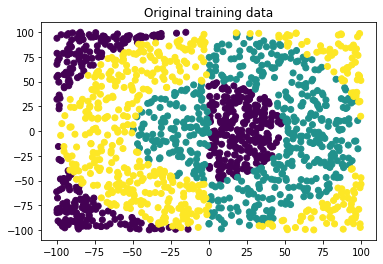

In [4]:
plot_fit(train_df[:,0], train_df[:,1], train_df[:,2], None, None, None)

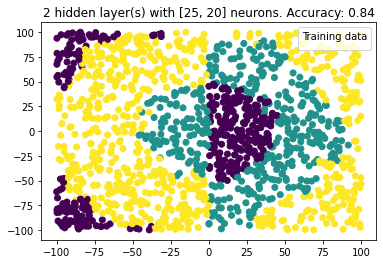

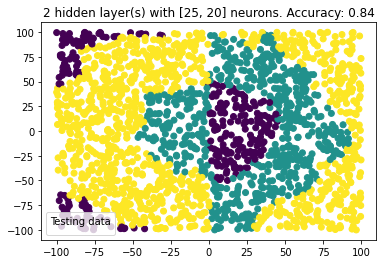

In [5]:
train_plot_wrap(train_data_rings, train_df[:,2], test_data_rings, test_df[:, 2], hidden_layers=[25, 20],
                n_outputs=3, epochs = 3000, last_activation_fun = 'softmax')

Skuteczność osiągnięta na zbiorze testowym jest niewiele wyższa (0.83 vs 0.81) niż ta na zbiorze treningowym. Warto zauważyć, że zbiór testowy zawiera więcej obserwacji niż treningowy.
## Porównanie czasów i skuteczności działania
Celem porównania czasu i skuteczności działania sieci z funkcją liniową oraz softmax w ostaniej warstwie, utworzone zostały dwie, identyczne poza tym parametrem sieci. Proces trenowania odbył się na zmniejszonej liczbie iteracji.

#### softmax:

In [17]:
nn1 = Net(n_inputs = 2, hidden_neurons_n=[25, 20], n_outputs=3, weights='Xavier', hidden_activation_fun=sigmoid,
                 last_activation_fun='softmax')

In [18]:
%%timeit -r 5
nn1.train(train_data_rings, optimisation='rmsprop', optimisation_param=0.99, epochs = 100, batch_size=50,
         plot = False, verbose=False)

5.27 s ± 26.7 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


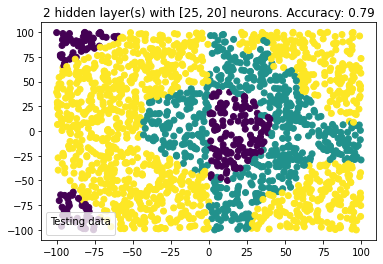

In [19]:
score1 = nn1.predict(test_data_rings[:,0])
plot_fit(test_df[:,0], test_df[:,1], np.argmax(score1, axis = 1), test_df[:,2], 'Testing', [25, 20])

#### funkcja liniowa:

In [20]:
nn2 = Net(n_inputs = 2, hidden_neurons_n=[25, 20], n_outputs=3, weights='Xavier', hidden_activation_fun=sigmoid,
                 last_activation_fun='linear')

In [21]:
%%timeit -r 5
nn2.train(train_data_rings, optimisation='rmsprop', optimisation_param=0.99, epochs = 100, batch_size=50, plot = False, verbose=False)

5.1 s ± 19.6 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


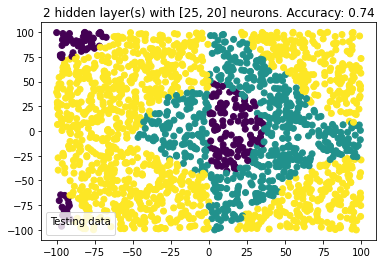

In [22]:
score2 = nn2.predict(test_data_rings[:,0])
plot_fit(test_df[:,0], test_df[:,1], np.argmax(score2, axis = 1), test_df[:,2], 'Testing', [25, 20])

#### Wnioski
Wyniki osiągnięte przez sieć z softmax jako funkcją aktywacji ostatniego zbioru są odrobinę wyższe. Czas działania obu wersji sieci był porównywalny, z delikatnym wskazaniem na korzyść funkcji liniowej.
# 2. zbiór danych - `easy`
Zbiór danych `easy` - zgodnie z nazwą - jest najłatwiejszy dla klasyfikujących sieci neuronowe. Prezentacja w przestrzeni kartezjańskiej wskazuje, że dane są podzielone na dwie klasy za pomocą funkcji liniowej. Sieć z jedną ukrytą warstwą o 3 neuronach już w 10 epokach dobrze sobie radzi z postawionym przed nią zagadnieniem.

In [23]:
train_df2 = pd.read_csv('../dane/mio1/classification/easy-training.csv', dtype='float128').to_numpy()
test_df2 = pd.read_csv('../dane/mio1/classification/easy-test.csv', dtype='float128').to_numpy()

train_labels2 = np.zeros((len(train_df2), 2))

for i, j in enumerate(train_df2[:,2]):
    train_labels2[i, int(j)] = 1
    
train_data_easy = np.array([
    np.array([[x_i, y_i], [c_1, c_2]])
    for x_i, y_i, c_1, c_2 in zip(
        train_df2[:,0],
        train_df2[:,1],
        train_labels2[:,0],
        train_labels2[:,1])])

test_labels2 = np.zeros((len(test_df2), 2))

for i, j in enumerate(test_df2[:,2]):
    test_labels2[i, int(j)] = 1
    
test_data_easy = np.array([
    np.array([[x_i, y_i], [c_1, c_2]])
    for x_i, y_i, c_1, c_2 in zip(
        test_df2[:,0],
        test_df2[:,1],
        test_labels2[:,0],
        test_labels2[:,1])])

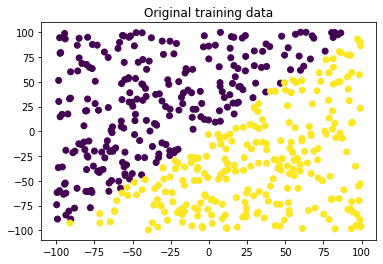

In [24]:
plot_fit(train_df2[:,0], train_df2[:,1], train_df2[:,2], None, None, None)

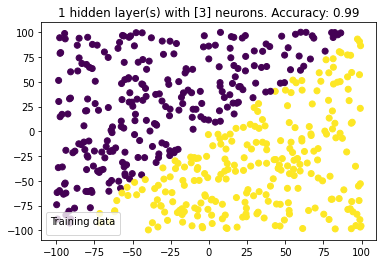

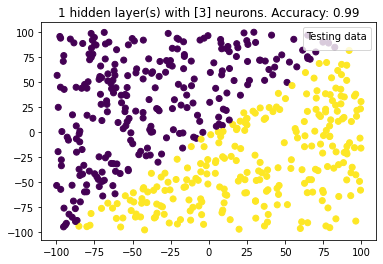

In [25]:
train_plot_wrap(train_data_easy, train_df2[:,2], test_data_easy, test_df2[:, 2], hidden_layers=[3],
                n_outputs=2, epochs = 10, last_activation_fun = 'softmax')

## Porównanie czasów i skuteczności działania
#### softmax

In [26]:
nn1 = Net(n_inputs = 2, hidden_neurons_n=[2], n_outputs=2, weights='Xavier', hidden_activation_fun=sigmoid,
                 last_activation_fun='softmax')

In [27]:
%%timeit
nn1.train(train_data_easy, optimisation='rmsprop', optimisation_param=0.99, epochs = 2, batch_size=50,
         plot = False, verbose=False)

8.1 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


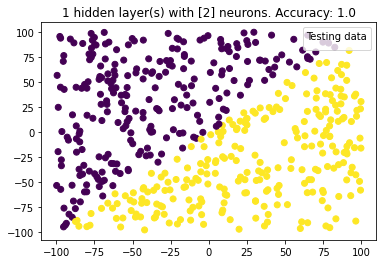

In [28]:
score1 = nn1.predict(test_data_easy[:,0])
plot_fit(test_df2[:,0], test_df2[:,1], np.argmax(score1, axis = 1), test_df2[:,2], 'Testing', [2])

#### funkcja liniowa

In [29]:
nn2 = Net(n_inputs = 2, hidden_neurons_n=[2], n_outputs=2, weights='Xavier', hidden_activation_fun=sigmoid,
                 last_activation_fun='linear')

In [30]:
%%timeit
nn2.train(test_data_easy, optimisation='rmsprop', optimisation_param=0.99, epochs = 2, batch_size=50,
         plot = False, verbose=False)

7.28 ms ± 82.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


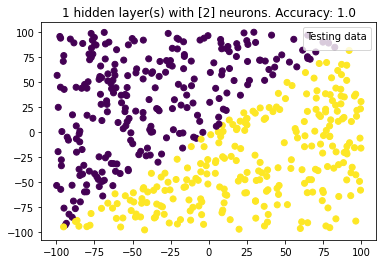

In [31]:
score2 = nn2.predict(test_data_easy[:,0])
plot_fit(test_df2[:,0], test_df2[:,1], np.argmax(score2, axis = 1), test_df2[:,2], 'Testing', [2])

Ponownie obie funkcje aktywacji osiągnęły podobną skuteczność - zadanie nie było dla nich dużym wyzwaniem. Czas działania sieci z funkcją liniową ponownie był odrobinę krótszy.

# 3. zbiór danych - `xor3`
Zbiór danych `xor3` skłąda się z _ obserwacji przypisanych do dwóch klas - ponownie klasyfikacja binarna. Poziom skomplikowania przypisania klas sprawił, że ponownie zdecydowałem się na architekturę składającą się z dwóch warstw ukrytych zawierających 25 i 20 neuronów.

In [32]:
train_df3 = pd.read_csv('../dane/mio1/classification/xor3-training.csv', dtype='float128').to_numpy()
test_df3 = pd.read_csv('../dane/mio1/classification/xor3-test.csv', dtype='float128').to_numpy()

train_labels3 = np.zeros((len(train_df3), 2))

for i, j in enumerate(train_df3[:,2]):
    train_labels3[i, int(j)] = 1

train_data_xor = np.array([
    np.array([[x_i, y_i], [c_1, c_2]])
    for x_i, y_i, c_1, c_2 in zip(
        train_df3[:,0],
        train_df3[:,1],
        train_labels3[:,0],
        train_labels3[:,1])])


test_labels3 = np.zeros((len(test_df3), 2))

for i, j in enumerate(test_df3[:,2]):
    test_labels3[i, int(j)] = 1

test_data_xor = np.array([
    np.array([[x_i, y_i], [l, r]])
    for x_i, y_i, l, r in zip(
        test_df3[:,0],
        test_df3[:,1],
        test_labels3[:,0],
        test_labels3[:,1])])

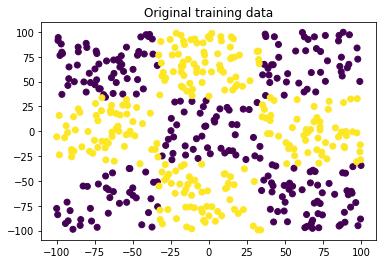

In [33]:
plot_fit(train_df3[:,0], train_df3[:,1], train_df3[:,2], None, None, None)

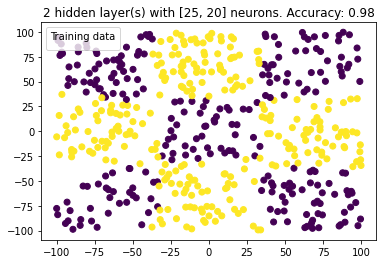

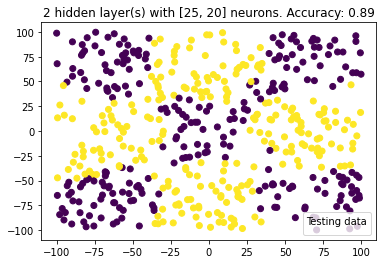

In [34]:
train_plot_wrap(train_data_xor, train_df3[:,2], test_data_xor, test_df3[:, 2], hidden_layers=[25, 20],
                n_outputs=2, epochs = 2000, last_activation_fun = 'softmax')

## Porównanie czasów i skuteczności działania
#### softmax

In [35]:
nn1 = Net(n_inputs = 2, hidden_neurons_n=[25, 20], n_outputs=2, weights='Xavier', hidden_activation_fun=sigmoid,
                 last_activation_fun='softmax')

In [36]:
%%timeit
nn1.train(train_data_xor, optimisation='rmsprop', optimisation_param=0.99, epochs = 700, batch_size=50,
         plot = False, verbose=False)

12.1 s ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


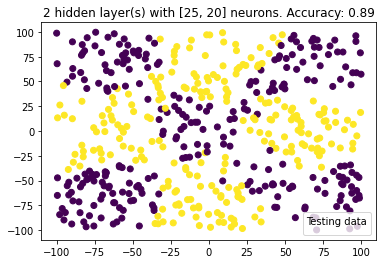

In [37]:
score1 = nn1.predict(test_data_xor[:,0])
plot_fit(test_df3[:,0], test_df3[:,1], np.argmax(score1, axis = 1), test_df3[:,2], 'Testing', [25, 20])

#### funkcja liniowa

In [38]:
nn2 = Net(n_inputs = 2, hidden_neurons_n=[25, 20], n_outputs=2, weights='Xavier', hidden_activation_fun=sigmoid,
                 last_activation_fun='linear')

In [39]:
%%timeit
nn2.train(train_data_xor, optimisation='rmsprop', optimisation_param=0.99, epochs = 700, batch_size=50,
         plot = False, verbose=False, )

11.8 s ± 69.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


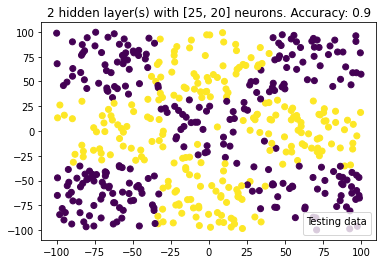

In [40]:
score2 = nn2.predict(test_data_xor[:,0])
plot_fit(test_df3[:,0], test_df3[:,1], np.argmax(score2, axis = 1), test_df3[:,2], 'Testing', [25, 20])

Wnioski są podobne jak w przypadku poprzednich eksperymentów. Skuteczność i czas działania nie różnią się znacząco - różnica nie wynosi więcej niż 10%. Jednak operacje wykonywane w trakcie propagacji wstecznej, w szczególności obliczanie i wymnażanie przez trójwymiarową tablicę jakobianów, pomimo że wykonane wektorowo, najwyrażniej odrobinę opóźniają proces trenowania sieci. Niemniej, klasyfikatory osiągają wysoką skuteczność na danych testowych.